<a href="https://colab.research.google.com/github/marifauzan/myocardial-infarction-prediction-as-an-element-of-preventive-medicine-with-ensemble-learning/blob/main/Deteksi_Myocardial_Infarction_sebagai_elemen_dalam_pengobatan_pencegahan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import randint

## Dataset 2



This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland: 303 observations
Hungarian: 294 observations
Switzerland: 123 observations
Long Beach VA: 200 observations
Stalog (Heart) Data Set: 270 observations
Total: 1190 observations
Duplicated: 272 observations

Final dataset: 918 observations

Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

In [ ]:
data = pd.read_csv('heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# define a dictionary to map
sex_map = {'M': 0, 'F': 1}
ch_map = {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3}
restecg_map = {'Normal': 0, 'ST': 1, 'LVH': 2}
exang_map = {'N': 0, 'Y': 1,}
slope_map = {'Up': 0, 'Flat': 1, 'Down': 2}

# use the map() method to replace the values
data['Sex'] = data['Sex'].map(sex_map)
data['ChestPainType'] = data['ChestPainType'].map(ch_map)
data['RestingECG'] = data['RestingECG'].map(restecg_map)
data['ExerciseAngina'] = data['ExerciseAngina'].map(exang_map)
data['ST_Slope'] = data['ST_Slope'].map(slope_map)

# Specify the column names you want to scale
columns_to_scale = ['Age','RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a new DataFrame with only the columns to scale
data_to_scale = data[columns_to_scale]

# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and perform the transformation
scaled_data = scaler.fit_transform(data_to_scale)

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Replace the original columns in the df with the scaled columns
data[columns_to_scale] = scaled_df

data.rename(columns={'HeartDisease': 'condition'}, inplace=True)

In [ ]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,condition
0,0.244898,0,1,0.70,0.479270,0,0,0.788732,0,0.295455,0,0
1,0.428571,1,2,0.80,0.298507,0,0,0.676056,0,0.409091,1,1
2,0.183673,0,1,0.65,0.469320,0,1,0.267606,0,0.295455,0,0
3,0.408163,1,3,0.69,0.354892,0,0,0.338028,1,0.465909,1,1
4,0.530612,0,2,0.75,0.323383,0,0,0.436620,0,0.295455,0,0


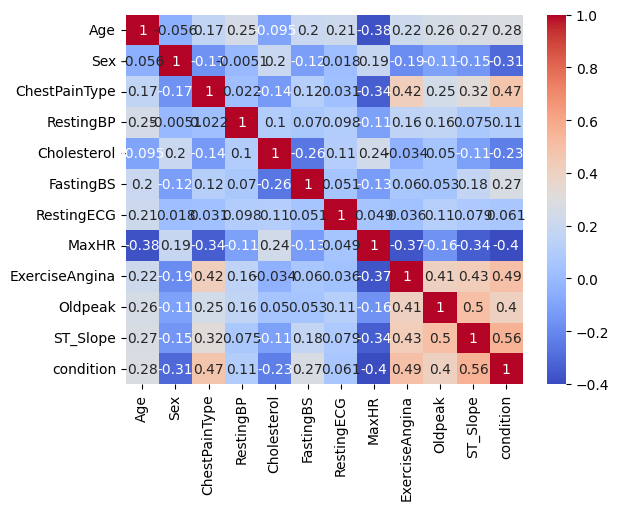

In [ ]:
# Plot the heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

# Show the plot
plt.show()

In [ ]:
cor_target = abs(data.corr()["condition"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.5]
relevant_features

ST_Slope     0.558771
condition    1.000000
Name: condition, dtype: float64

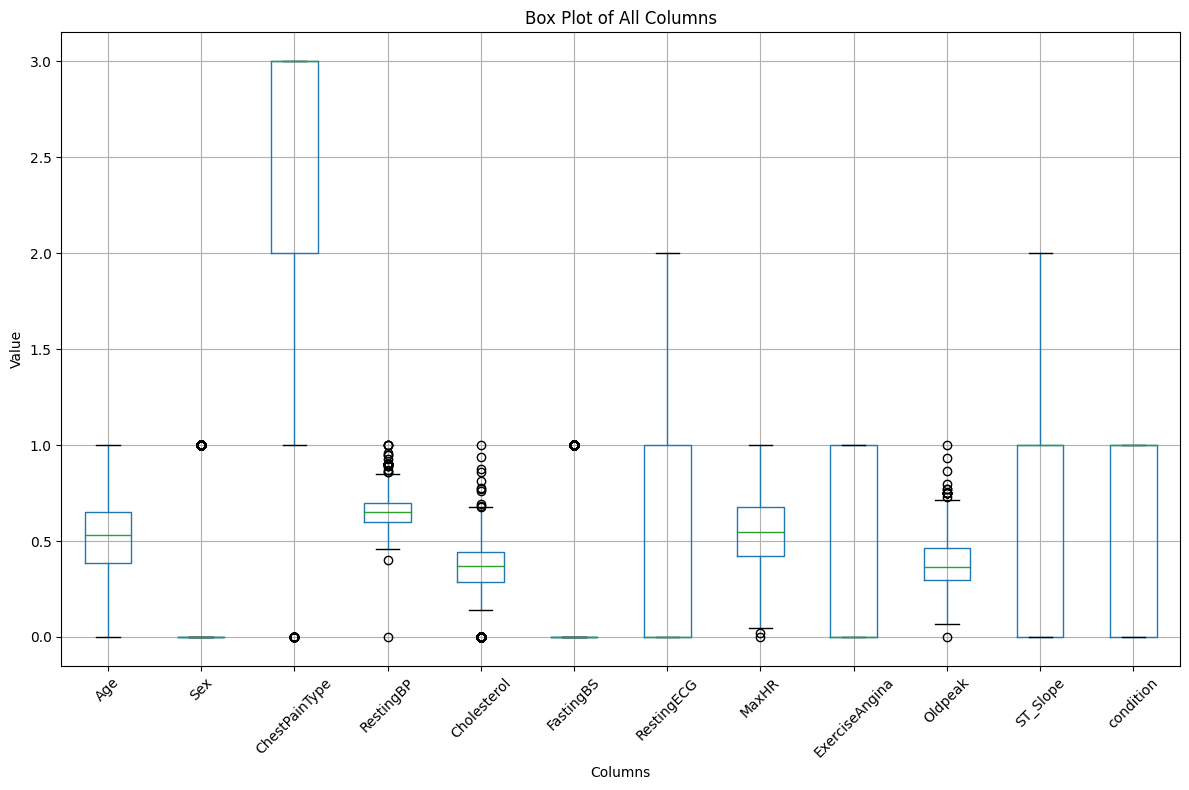

In [ ]:
# Create a box plot for each column
plt.figure(figsize=(12, 8))
data.boxplot()

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Value')
plt.title('Box Plot of All Columns')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
data.condition.value_counts()

1    508
0    410
Name: condition, dtype: int64

In [ ]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n", data.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
condition         0
dtype: int64


In [ ]:
# Splitting the data into training and testing sets
X = data.drop(columns=['condition'])
y = data['condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stacking
meta-model yang akan digunakan adalah Logistic Regression.

## Stacked Generalization

### Base Model

In [ ]:
# Define the base models
base_models = [
    ('lr', LogisticRegression()),
    ('svc', SVC()),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier())
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(stacking_model, 'stacking_model.pkl')

# Make predictions on the test set
predictions = stacking_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_stacking = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 88.04%
Precision: 91.26%
Recall: 87.85%
Specificity: 88.31%
F1 Score: 89.52%
Confusion Matrix:
[[68  9]
 [13 94]]
Cross-Validation Scores: [0.84782609 0.85326087 0.83152174 0.81967213 0.78688525]
Mean Cross-Validation Accuracy: 0.8278332145402707


### Hyperparameter Tuning

In [ ]:
# Define the base models
base_models = [
    ('lr', LogisticRegression()),
    ('svc', SVC()),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier())
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Define the parameter grid
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'final_estimator__solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(stacking_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'Stacked Generalization.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 88.04%
Precision: 91.26%
Recall: 87.85%
Specificity: 88.31%
F1 Score: 89.52%
Confusion Matrix:
[[68  9]
 [13 94]]
Cross-Validation Scores: [0.91304348 0.8423913  0.83695652 0.86338798 0.86885246]
Mean Cross-Validation Accuracy: 0.8649263483012593


# Boosting
Base-model yang digunakan adalah Decision Tree

## Adaptative boosting (AdaBoost)

### Base Model

In [ ]:
# Create the AdaBoost model with Decision Tree as base model
adaboost_model = AdaBoostClassifier(random_state=42)

# Train the model
adaboost_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(adaboost_model, 'adaboost.pkl')

# Make predictions on the test set
predictions = adaboost_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_adaboost = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(adaboost_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 84.78%
Precision: 91.58%
Recall: 81.31%
Specificity: 89.61%
F1 Score: 86.14%
Confusion Matrix:
[[69  8]
 [20 87]]
Cross-Validation Scores: [0.83695652 0.8423913  0.79891304 0.85245902 0.75956284]
Mean Cross-Validation Accuracy: 0.818056545497743


### Tuning AdaBoost


In [ ]:
# Create the base Decision Tree model
base_model = DecisionTreeClassifier(random_state=42)

# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(estimator=base_model, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'base_estimator__max_depth': [2, 3, 4]  # Max depth of the decision tree
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(adaboost_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'AdaBoost.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'ba

Accuracy: 87.50%
Precision: 88.89%
Recall: 89.72%
Specificity: 84.42%
F1 Score: 89.30%
Confusion Matrix:
[[65 12]
 [11 96]]
Cross-Validation Scores: [0.88586957 0.83152174 0.79347826 0.86885246 0.8579235 ]
Mean Cross-Validation Accuracy: 0.8475291043003089


## Gradient Boosting Machines (GBM)

### Base Model

In [ ]:
# Create the Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(gbm_model, 'gbm_model.pkl')

# Make predictions on the test set
predictions = gbm_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_gbm = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(gbm_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 88.04%
Precision: 91.26%
Recall: 87.85%
Specificity: 88.31%
F1 Score: 89.52%
Confusion Matrix:
[[68  9]
 [13 94]]
Cross-Validation Scores: [0.86956522 0.8423913  0.82608696 0.80327869 0.74863388]
Mean Cross-Validation Accuracy: 0.8179912093133762


### Tuning GBM

In [ ]:
# Create the Gradient Boosting model
gbm_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(gbm_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'GBM.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 88.04%
Precision: 91.26%
Recall: 87.85%
Specificity: 88.31%
F1 Score: 89.52%
Confusion Matrix:
[[68  9]
 [13 94]]
Cross-Validation Scores: [0.89673913 0.875      0.83152174 0.87978142 0.8579235 ]
Mean Cross-Validation Accuracy: 0.8681931575196009


## Extreme Gradient Boosting Machine (XGBM)

### Base

In [ ]:
# Create the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(xgb_model, 'xgb_model.pkl')

# Make predictions on the test set
predictions = xgb_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_xgboost = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 88.04%
Precision: 91.26%
Recall: 87.85%
Specificity: 88.31%
F1 Score: 89.52%
Confusion Matrix:
[[68  9]
 [13 94]]
Cross-Validation Scores: [0.82065217 0.85869565 0.83152174 0.80874317 0.7431694 ]
Mean Cross-Validation Accuracy: 0.8125564267046805


### Tuning XGBM

In [ ]:
# Create the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0, 0.5]
}
# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'XGBoost.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 87.50%
Precision: 91.18%
Recall: 86.92%
Specificity: 88.31%
F1 Score: 89.00%
Confusion Matrix:
[[68  9]
 [14 93]]
Cross-Validation Scores: [0.89673913 0.86956522 0.8423913  0.87431694 0.84699454]
Mean Cross-Validation Accuracy: 0.8660014255167499


## Light Gradient Boosting Machine (LGBM)

### Base

In [ ]:
# Create the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(lgb_model, 'lgb_model.pkl')

# Make predictions on the test set
predictions = lgb_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_lgbm = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 85.87%
Precision: 90.10%
Recall: 85.05%
Specificity: 87.01%
F1 Score: 87.50%
Confusion Matrix:
[[67 10]
 [16 91]]
Cross-Validation Scores: [0.85869565 0.86413043 0.82065217 0.82513661 0.7431694 ]
Mean Cross-Validation Accuracy: 0.8223568543597054


### Tuning LGBM

In [ ]:
# Create the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.075, 0.1],
    'max_depth': [3, 4, 5],
    'num_leaves': [20, 25, 30]
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(lgb_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'LGBM.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 87.50%
Precision: 91.18%
Recall: 86.92%
Specificity: 88.31%
F1 Score: 89.00%
Confusion Matrix:
[[68  9]
 [14 93]]
Cross-Validation Scores: [0.89130435 0.85326087 0.8423913  0.87978142 0.8579235 ]
Mean Cross-Validation Accuracy: 0.8649322879543835


## CatBoost

### Base Model

In [ ]:
# Create the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=False)

# Train the model
catboost_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(catboost_model, 'catboost_model.pkl')

# Make predictions on the test set
pred_prob = catboost_model.predict_proba(X_test)
predictions = pred_prob.argmax(axis=1)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_catboost = accuracy
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(catboost_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 89.13%
Precision: 89.13%
Recall: 89.13%
Specificity: 87.01%
F1 Score: 89.13%
Confusion Matrix:
[[67 10]
 [10 97]]
Cross-Validation Scores: [0.86413043 0.84782609 0.84782609 0.84699454 0.78142077]
Mean Cross-Validation Accuracy: 0.83763958184842


### Tuning

In [ ]:
# Create the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=False)

# Define the parameter grid
param_grid = {
    'iterations': [200, 300, 400, 500, 600],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'depth': [4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(catboost_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'CatBoost.pkl')

# Make predictions on the test set
pred_prob = best_model.predict_proba(X_test)
predictions = pred_prob.argmax(axis=1)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 88.59%
Precision: 88.69%
Recall: 88.59%
Specificity: 88.31%
F1 Score: 88.61%
Confusion Matrix:
[[68  9]
 [12 95]]
Cross-Validation Scores: [0.88043478 0.88043478 0.83152174 0.8852459  0.86338798]
Mean Cross-Validation Accuracy: 0.8682050368258494


# Bagging
Base-model yang digunakan adalah Decision Tree

## Bagging

### Base Model

In [ ]:
# Create the base Decision Tree model
base_model = DecisionTreeClassifier()

# Create the Bagging ensemble model
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# Train the model
bagging_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(bagging_model, 'bagging_model.pkl')

# Make predictions on the test set
predictions = bagging_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_bagging = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(bagging_model, X, y, cv=5, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 86.41%
Precision: 91.84%
Recall: 84.11%
Specificity: 89.61%
F1 Score: 87.80%
Confusion Matrix:
[[69  8]
 [17 90]]
Cross-Validation Scores: [0.80978261 0.79891304 0.80434783 0.80327869 0.71584699]
Mean Cross-Validation Accuracy: 0.7864338322641958


### Tuning Hyperparameter Bagging


In [ ]:
# Create the base Decision Tree model
base_model = DecisionTreeClassifier()

# Create the Bagging ensemble model
bagging_model = BaggingClassifier(base_model, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_samples': [0.8, 0.9, 1.0],
    'max_features': [0.8, 0.9, 1.0],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10]
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(bagging_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'Bagging.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='accuracy')

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_est

Accuracy: 89.13%
Precision: 92.23%
Recall: 88.79%
Specificity: 89.61%
F1 Score: 90.48%
Confusion Matrix:
[[69  8]
 [12 95]]
Cross-Validation Scores: [0.90217391 0.85326087 0.85869565 0.87978142 0.86338798]
Mean Cross-Validation Accuracy: 0.8714599667379425


## Random Forest

### Base Model

In [ ]:
# Create the base Decision Tree model
base_model = DecisionTreeClassifier()

# Create the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(random_forest_model, 'random_forest_model.pkl')

# Make predictions on the test set
predictions = random_forest_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_random_forest = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(random_forest_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 82.61%
Precision: 89.47%
Recall: 79.44%
Specificity: 87.01%
F1 Score: 84.16%
Confusion Matrix:
[[67 10]
 [22 85]]
Cross-Validation Scores: [0.83152174 0.78804348 0.83152174 0.83060109 0.71584699]
Mean Cross-Validation Accuracy: 0.7995070087906867


### Tuning RF

In [ ]:
# Create the base Decision Tree model
base_model = DecisionTreeClassifier()

# Create the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(random_forest_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'Random Forest.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

Accuracy: 89.67%
Precision: 92.31%
Recall: 89.72%
Specificity: 89.61%
F1 Score: 91.00%
Confusion Matrix:
[[69  8]
 [11 96]]


## Extra Trees

### Base Model

In [ ]:
# Create the Extra Trees model
extra_trees_model = ExtraTreesClassifier(n_estimators=10, random_state=42)

# Train the model
extra_trees_model.fit(X_train, y_train)

# Save the stacking model as a .pkl file
joblib.dump(extra_trees_model, 'extra_trees_model.pkl')

# Make predictions on the test set
predictions = extra_trees_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
accuracy_extra_trees = accuracy
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

# Perform cross-validation
cv_scores = cross_val_score(extra_trees_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Accuracy: 86.96%
Precision: 91.92%
Recall: 85.05%
Specificity: 89.61%
F1 Score: 88.35%
Confusion Matrix:
[[69  8]
 [16 91]]
Cross-Validation Scores: [0.85326087 0.80978261 0.82065217 0.85245902 0.73224044]
Mean Cross-Validation Accuracy: 0.8136790211451652


### Tuning

In [ ]:
# Create the Extra Trees model
extra_trees_model = ExtraTreesClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2']
}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(extra_trees_model, param_grid=param_grid, cv=skf, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and its hyperparameters
best_model = grid_search.best_estimator_

# Save the best model as a .pkl file
joblib.dump(best_model, 'Extra Trees.pkl')

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate metrics on test set
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)

# Print the metrics
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("Specificity: {:.2%}".format(specificity))  # Add this line
print("F1 Score: {:.2%}".format(f1))
print("Confusion Matrix:")
print(confusion)

Accuracy: 89.67%
Precision: 91.51%
Recall: 90.65%
Specificity: 88.31%
F1 Score: 91.08%
Confusion Matrix:
[[68  9]
 [10 97]]
